# # # SARCOS Dataset Preprocessing
# # 
# # ## Data Preparation Strategy
# # 
# # This notebook preprocesses the SARCOS dataset, which contains data for the inverse dynamics of a 7 degrees-of-freedom anthropomorphic robot arm. The dataset maps from a 21-dimensional input space (7 joint positions, 7 joint velocities, 7 joint accelerations) to the corresponding 7 joint torques.
# # 
# # The preprocessing includes:
# # 
# # 1. **Training Set**: Using the provided training split (44,484 samples)
# # 2. **Test Set**: Using the provided test split (4,449 samples)
# # 3. **Data Visualization**: Exploring the distribution of input features and target variables
# # 4. **Feature Normalization**: Standardizing the input features for better model performance


# %  
# % SARCOS Dataset Description
# %
# % The SARCOS dataset relates to an inverse dynamics problem for a seven degrees-of-freedom anthropomorphic robot arm.
# % The task is to map from a 21-dimensional input space (7 joint positions, 7 joint velocities, 7 joint accelerations) 
# % to the corresponding 7 joint torques.
# %
# % This is a standard dataset used in the evaluation of regression algorithms, particularly for high-dimensional, 
# % non-linear regression problems. The dataset consists of 44,484 training examples and 4,449 test examples.
# %     
# @RELATION SARCOS_Inverse_Dynamics
# 
# @ATTRIBUTE joint_pos_1 REAL
# @ATTRIBUTE joint_pos_2 REAL
# @ATTRIBUTE joint_pos_3 REAL
# @ATTRIBUTE joint_pos_4 REAL
# @ATTRIBUTE joint_pos_5 REAL
# @ATTRIBUTE joint_pos_6 REAL
# @ATTRIBUTE joint_pos_7 REAL
# @ATTRIBUTE joint_vel_1 REAL
# @ATTRIBUTE joint_vel_2 REAL
# @ATTRIBUTE joint_vel_3 REAL
# @ATTRIBUTE joint_vel_4 REAL
# @ATTRIBUTE joint_vel_5 REAL
# @ATTRIBUTE joint_vel_6 REAL
# @ATTRIBUTE joint_vel_7 REAL
# @ATTRIBUTE joint_acc_1 REAL
# @ATTRIBUTE joint_acc_2 REAL
# @ATTRIBUTE joint_acc_3 REAL
# @ATTRIBUTE joint_acc_4 REAL
# @ATTRIBUTE joint_acc_5 REAL
# @ATTRIBUTE joint_acc_6 REAL
# @ATTRIBUTE joint_acc_7 REAL
# @ATTRIBUTE torque_1 REAL
# @ATTRIBUTE torque_2 REAL
# @ATTRIBUTE torque_3 REAL
# @ATTRIBUTE torque_4 REAL
# @ATTRIBUTE torque_5 REAL
# @ATTRIBUTE torque_6 REAL
# @ATTRIBUTE torque_7 REAL

In [1]:
SARCOS_PATH = 'C:/Users/the_3/Documents/github/keras-functional-api/data/sarcos/sarcos_inv.csv'

In [2]:
import pandas as pd
from typing import List, Union, Tuple, Optional, Generator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from scipy.stats import gaussian_kde

In [3]:
def analyze_dataframe(df: pd.DataFrame) -> None:
    """
    Analyze a dataframe by printing its dimensions, column names, and statistics for each column.
    
    Parameters:
    - df (pd.DataFrame): The dataframe to analyze
    
    Returns:
    - None: This function only prints information, it doesn't return any values
    """
    # --- Get dataset dimensions ---
    num_rows, num_cols = df.shape
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_cols}")

    # --- Get column names with statistics ---
    print("\n--- Column Names and Statistics ---")
    for col in sorted(df.columns):
        stats = []
        try:
            # Attempt to get min/max - might fail for non-numeric/non-comparable types
            min_val = df[col].min()
            max_val = df[col].max()
            stats.append(f"Min: {min_val}")
            stats.append(f"Max: {max_val}")
        except TypeError:
            stats.append("Min/Max: NA")

        # Get unique count - works for most types
        unique_count = df[col].nunique()
        stats.append(f"Unique: {unique_count}")
        
        # Display column name with its statistics on the same line
        print(f"- {col:<25} | {' | '.join(stats)}")


# Load and analyze the dataset
try:
    # Load the dataset from the specified path
    df = pd.read_csv(SARCOS_PATH)
    
    # Analyze the loaded dataframe
    analyze_dataframe(df)
    
except FileNotFoundError:
    print(f"Error: File not found at '{SARCOS_PATH}'. Please provide the correct file path.")
except Exception as e:
    print(f"An error occurred: {e}")

Number of rows: 188318
Number of columns: 132

--- Column Names and Statistics ---
- Column1                   | Min: 1 | Max: 587633 | Unique: 188318
- Column10                  | Min: A | Max: B | Unique: 2
- Column100                 | Min: C | Max: T | Unique: 16
- Column101                 | Min: A | Max: O | Unique: 15
- Column102                 | Min: A | Max: U | Unique: 19
- Column103                 | Min: A | Max: J | Unique: 9
- Column104                 | Min: A | Max: N | Unique: 13
- Column105                 | Min: A | Max: Q | Unique: 17
- Column106                 | Min: A | Max: T | Unique: 20
- Column107                 | Min: A | Max: R | Unique: 17
- Column108                 | Min: A | Max: U | Unique: 20
- Column109                 | Min: A | Max: K | Unique: 11
- Column11                  | Min: A | Max: B | Unique: 2
- Column110                 | Min: A | Max: ZZ | Unique: 84
- Column111                 | Min: A | Max: Y | Unique: 131
- Column112             

In [7]:
def min_max_norm(data: Union[pd.DataFrame, pd.Series]) -> Union[pd.DataFrame, pd.Series]:
    """
    Apply min-max normalization to a pandas DataFrame or Series.
    If the min and max values of a column are the same, that column is replaced with zeros.

    Parameters:
    - cme_files (pd.DataFrame or pd.Series): The pandas DataFrame or Series to be normalized.

    Returns:
    - pd.DataFrame or pd.Series: Min-max normalized pandas DataFrame or Series.
    """

    # Function to normalize a single column
    def normalize_column(column: pd.Series) -> pd.Series:
        min_val = column.min()
        max_val = column.max()

        # Handle case where max and min are the same
        if min_val == max_val:
            return pd.Series(np.zeros_like(column), index=column.index)
        else:
            # Apply min-max normalization
            return (column - min_val) / (max_val - min_val)

    # Check if the input is a DataFrame
    if isinstance(data, pd.DataFrame):
        normalized_df = data.apply(normalize_column, axis=0)
        return normalized_df

    # Check if the input is a Series
    elif isinstance(data, pd.Series):
        return normalize_column(data)

    else:
        raise TypeError("Input must be a pandas DataFrame or Series")

In [8]:
def preprocess_asc_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the AllState Claims dataset features.
    
    Parameters:
    - df (pd.DataFrame): The dataframe to preprocess.
    
    Returns:
    - pd.DataFrame: The preprocessed dataframe.
    """
    # Preallocate a dictionary to store preprocessed data
    preprocessed_data = {}
    
    # Include Column132 with log transformation only (as it will be the target)
    preprocessed_data['log_loss'] = np.log(df['Column132'])
    
    # Binary columns (Column2-Column73): Apply binarization (A->0, B->1)
    binary_columns = [f'Column{i}' for i in range(2, 74)]
    for col in binary_columns:
        preprocessed_data[f'{col}_binary'] = df[col].map({'A': 0, 'B': 1})
    
    # Continuous columns (Column118-Column131): Apply min-max normalization
    continuous_columns = [f'Column{i}' for i in range(118, 132)]
    for col in continuous_columns:
        preprocessed_data[f'{col}_norm'] = min_max_norm(df[col])
    
    # Multiclass columns (Column74-Column117): Apply one-hot encoding
    multiclass_columns = [f'Column{i}' for i in range(74, 118)]
    for col in multiclass_columns:
        # Get unique values for this column
        unique_values = sorted(df[col].unique())
        
        # Create one-hot encoding for each unique value
        for value in unique_values:
            preprocessed_data[f'{col}_{value}'] = (df[col] == value).astype(int)
    
    # Column1 is likely an ID column, so we'll keep it as is
    preprocessed_data['id'] = df['Column1']
    
    return pd.DataFrame(preprocessed_data)

In [9]:
# preprocess the dataset
preprocessed_df = preprocess_asc_features(df)

# print the statistics of the preprocessed dataframe
analyze_dataframe(preprocessed_df)




Number of rows: 188318
Number of columns: 1083

--- Column Names and Statistics ---
- Column100_C               | Min: 0 | Max: 1 | Unique: 2
- Column100_D               | Min: 0 | Max: 1 | Unique: 2
- Column100_E               | Min: 0 | Max: 1 | Unique: 2
- Column100_F               | Min: 0 | Max: 1 | Unique: 2
- Column100_G               | Min: 0 | Max: 1 | Unique: 2
- Column100_H               | Min: 0 | Max: 1 | Unique: 2
- Column100_I               | Min: 0 | Max: 1 | Unique: 2
- Column100_J               | Min: 0 | Max: 1 | Unique: 2
- Column100_K               | Min: 0 | Max: 1 | Unique: 2
- Column100_M               | Min: 0 | Max: 1 | Unique: 2
- Column100_N               | Min: 0 | Max: 1 | Unique: 2
- Column100_O               | Min: 0 | Max: 1 | Unique: 2
- Column100_P               | Min: 0 | Max: 1 | Unique: 2
- Column100_R               | Min: 0 | Max: 1 | Unique: 2
- Column100_S               | Min: 0 | Max: 1 | Unique: 2
- Column100_T               | Min: 0 | Max: 1 

In [10]:
def save_and_verify_dataset(
    df: pd.DataFrame, 
    output_path: str, 
    dataset_name: str = "Dataset", 
    target_column: str = "log_loss",
    verify: bool = True
) -> pd.DataFrame:
    """
    Save a dataframe to CSV and optionally verify it was saved correctly.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe to save
    output_path : str
        Path where the CSV file should be saved
    dataset_name : str, optional
        Name of the dataset for display in verification messages
    target_column : str, optional
        Name of the target column to verify its position
    verify : bool, optional
        Whether to load and verify the saved file
        
    Returns:
    --------
    pd.DataFrame
        The loaded dataframe if verify=True, otherwise None
    """
    # Save the dataframe to CSV
    df.to_csv(output_path, index=False)
    print(f"{dataset_name} saved to: {output_path}")
    
    if not verify:
        return None
    
    # Load the saved CSV file to verify it was saved correctly
    loaded_df = pd.read_csv(output_path)
    print(f"\nLoaded {dataset_name.lower()} from: {output_path}")
    print(f"Shape of loaded {dataset_name.lower()}: {loaded_df.shape}")
    
    # Analyze the loaded dataframe to verify preprocessing was successful
    print(f"\nAnalysis of the loaded {dataset_name.lower()}:")
    analyze_dataframe(loaded_df)
    
    # Verify that the target column is the last column
    print(f"\nVerifying target column position for {dataset_name.lower()}:")
    print(f"Last column in loaded {dataset_name.lower()}: {loaded_df.columns[-1]}")
    
    if loaded_df.columns[-1] == target_column:
        print(f"✓ Target column '{target_column}' is correctly positioned as the last column")
    else:
        print(f"✗ Target column '{target_column}' is not in the expected position")
    
    return loaded_df

In [11]:
# Rearrange columns to place ln_peak_intensity last
cols = [col for col in preprocessed_df.columns if col != 'log_loss']
cols.append('log_loss')
preprocessed_df = preprocessed_df[cols]

# Define the output path in the same directory as the original file
output_dir = os.path.dirname(SARCOS_PATH)
output_path = os.path.join(output_dir, 'allstate_claims_preprocessed.csv')

# Print column order before saving
print("\nColumns in the file (last one is the target):")
print(', '.join(cols))

# Save and verify the dataset using the function
loaded_df = save_and_verify_dataset(
    df=preprocessed_df,
    output_path=output_path,
    dataset_name="Preprocessed data",
    target_column="log_loss",
    verify=True
)


Columns in the file (last one is the target):
Column2_binary, Column3_binary, Column4_binary, Column5_binary, Column6_binary, Column7_binary, Column8_binary, Column9_binary, Column10_binary, Column11_binary, Column12_binary, Column13_binary, Column14_binary, Column15_binary, Column16_binary, Column17_binary, Column18_binary, Column19_binary, Column20_binary, Column21_binary, Column22_binary, Column23_binary, Column24_binary, Column25_binary, Column26_binary, Column27_binary, Column28_binary, Column29_binary, Column30_binary, Column31_binary, Column32_binary, Column33_binary, Column34_binary, Column35_binary, Column36_binary, Column37_binary, Column38_binary, Column39_binary, Column40_binary, Column41_binary, Column42_binary, Column43_binary, Column44_binary, Column45_binary, Column46_binary, Column47_binary, Column48_binary, Column49_binary, Column50_binary, Column51_binary, Column52_binary, Column53_binary, Column54_binary, Column55_binary, Column56_binary, Column57_binary, Column58_

In [12]:
def stratified_split(
        df: pd.DataFrame,
        label_column: str = 'log_loss',
        seed: int = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataframe into training and testing sets using stratified sampling based on the label column.
    Training set will contain 2/3 of the data, and testing set will contain 1/3.
    
    Parameters:
    df (pd.DataFrame): The dataframe to split.
    label_column (str): The name of the column to use as the label for stratification.
    seed (int): Random seed for reproducibility. Default is None.
    
    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
        - df_train: DataFrame for the training set (2/3 of data)
        - df_test: DataFrame for the testing set (1/3 of data)
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Random seed set to: {seed}")
    
    # Extract labels
    y = df[label_column].values.reshape(-1, 1)
    
    # Sort the data by the labels
    sorted_indices = np.argsort(y, axis=0).flatten()
    df_sorted = df.iloc[sorted_indices].reset_index(drop=True)
    print(f"Data sorted by {label_column} values")
    
    # Calculate the number of samples
    num_samples = len(df)
    
    # Lists to hold training and testing indices
    train_indices, test_indices = [], []
    
    # Divide into groups of 3 and split: 2 for training, 1 for testing
    for i in range(0, num_samples, 3):
        group_indices = list(range(i, min(i + 3, num_samples)))
        print(f"Group {i//3} size: {len(group_indices)}", end=',')
        
        # Take 1/3 for testing, 2/3 for training
        split_point = max(1, len(group_indices) // 3)
        test_group = group_indices[:split_point]
        train_group = group_indices[split_point:]
        
        test_indices.extend(test_group)
        train_indices.extend(train_group)
    
    # Create the dataframes
    df_train = df_sorted.iloc[train_indices].reset_index(drop=True)
    df_test = df_sorted.iloc[test_indices].reset_index(drop=True)
    
    # Print splitting statistics
    print(f"Total samples: {num_samples}")
    print(f"Train samples: {len(df_train)} ({len(df_train)/num_samples:.2%})")
    print(f"Test samples: {len(df_test)} ({len(df_test)/num_samples:.2%})")
    print(f"Train {label_column} range: {df_train[label_column].min():.4f} to {df_train[label_column].max():.4f}")
    print(f"Test {label_column} range: {df_test[label_column].min():.4f} to {df_test[label_column].max():.4f}")
    
    return df_train, df_test

In [13]:
# split the dataset into training and testing sets
df_train, df_test = stratified_split(preprocessed_df)

# print the statistics of the training and testing sets
analyze_dataframe(df_train)
analyze_dataframe(df_test)



Data sorted by log_loss values
Group 0 size: 3,Group 1 size: 3,Group 2 size: 3,Group 3 size: 3,Group 4 size: 3,Group 5 size: 3,Group 6 size: 3,Group 7 size: 3,Group 8 size: 3,Group 9 size: 3,Group 10 size: 3,Group 11 size: 3,Group 12 size: 3,Group 13 size: 3,Group 14 size: 3,Group 15 size: 3,Group 16 size: 3,Group 17 size: 3,Group 18 size: 3,Group 19 size: 3,Group 20 size: 3,Group 21 size: 3,Group 22 size: 3,Group 23 size: 3,Group 24 size: 3,Group 25 size: 3,Group 26 size: 3,Group 27 size: 3,Group 28 size: 3,Group 29 size: 3,Group 30 size: 3,Group 31 size: 3,Group 32 size: 3,Group 33 size: 3,Group 34 size: 3,Group 35 size: 3,Group 36 size: 3,Group 37 size: 3,Group 38 size: 3,Group 39 size: 3,Group 40 size: 3,Group 41 size: 3,Group 42 size: 3,Group 43 size: 3,Group 44 size: 3,Group 45 size: 3,Group 46 size: 3,Group 47 size: 3,Group 48 size: 3,Group 49 size: 3,Group 50 size: 3,Group 51 size: 3,Group 52 size: 3,Group 53 size: 3,Group 54 size: 3,Group 55 size: 3,Group 56 size: 3,Group 57 s

In [14]:
def plot_dfs_distr(*dataframes: List[pd.DataFrame], 
                   target_column: str = 'log_loss',
                   labels: Optional[List[str]] = None, 
                   figsize: Tuple[int, int] = (12, 6), 
                   bins: int = 5) -> None:
    """
    Plot the distribution of a target column for multiple dataframes for comparison.
    
    Parameters:
    -----------
    *dataframes : List[pd.DataFrame]
        Variable number of pandas DataFrames to compare
    target_column : str, default='log_loss'
        The column name to plot distributions for
    labels : Optional[List[str]], default=None
        List of labels for each dataframe (for the legend)
    figsize : Tuple[int, int], default=(12, 6)
        Tuple specifying figure size (width, height)
    bins : int, default=10
        Number of bins for the histogram
        
    Returns:
    --------
    None
        Displays the plot but doesn't return any value
    """
    # Generate default labels if none provided
    if labels is None:
        labels = [f"DataFrame {i+1}" for i in range(len(dataframes))]
    
    # Create figure with two subplots - KDE and histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Set a different color for each dataframe
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot KDE (Kernel Density Estimation) for each dataframe on the first subplot
    for i, df in enumerate(dataframes):
        sns.kdeplot(
            df[target_column], 
            ax=ax1, 
            label=labels[i], 
            color=colors[i % len(colors)],
            fill=False,  # Don't fill colors on the KDE
            alpha=1.0    # Full opacity for clear lines
        )
    
    # Set titles and labels for KDE plot
    ax1.set_title(f'Density Distribution of {target_column}')
    ax1.set_xlabel(target_column)
    ax1.set_ylabel('Density')
    ax1.legend()
    
    # Plot histograms on the second subplot with non-overlapping bars
    bin_edges = np.linspace(
        min(df[target_column].min() for df in dataframes),
        max(df[target_column].max() for df in dataframes),
        bins + 1
    )
    
    bar_width = (bin_edges[1] - bin_edges[0]) / (len(dataframes) + 0.2)
    
    for i, df in enumerate(dataframes):
        # Calculate histogram values
        hist, _ = np.histogram(df[target_column], bins=bin_edges, density=True)
        # Calculate the center position for each bar group
        bar_positions = bin_edges[:-1] + i * bar_width
        
        ax2.bar(
            bar_positions, 
            hist,
            width=bar_width * 0.9,  # Slightly narrower to create separation
            alpha=0.8, 
            label=labels[i],
            color=colors[i % len(colors)]
        )
    
    # Set titles and labels for histogram
    ax2.set_title(f'Histogram of {target_column}')
    ax2.set_xlabel(target_column)
    ax2.set_ylabel('Normalized Frequency')
    ax2.legend()
    
    # Add descriptive statistics below the plots
    for i, df in enumerate(dataframes):
        stats = (
            f"{labels[i]}: "
            f"Mean={df[target_column].mean():.2f}, "
            f"Median={df[target_column].median():.2f}, "
            f"Min={df[target_column].min():.2f}, "
            f"Max={df[target_column].max():.2f}"
        )
        plt.figtext(0.5, 0.01 - i*0.03, stats, ha='center', fontsize=9)
    
    # Adjust layout to make room for statistics text
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()


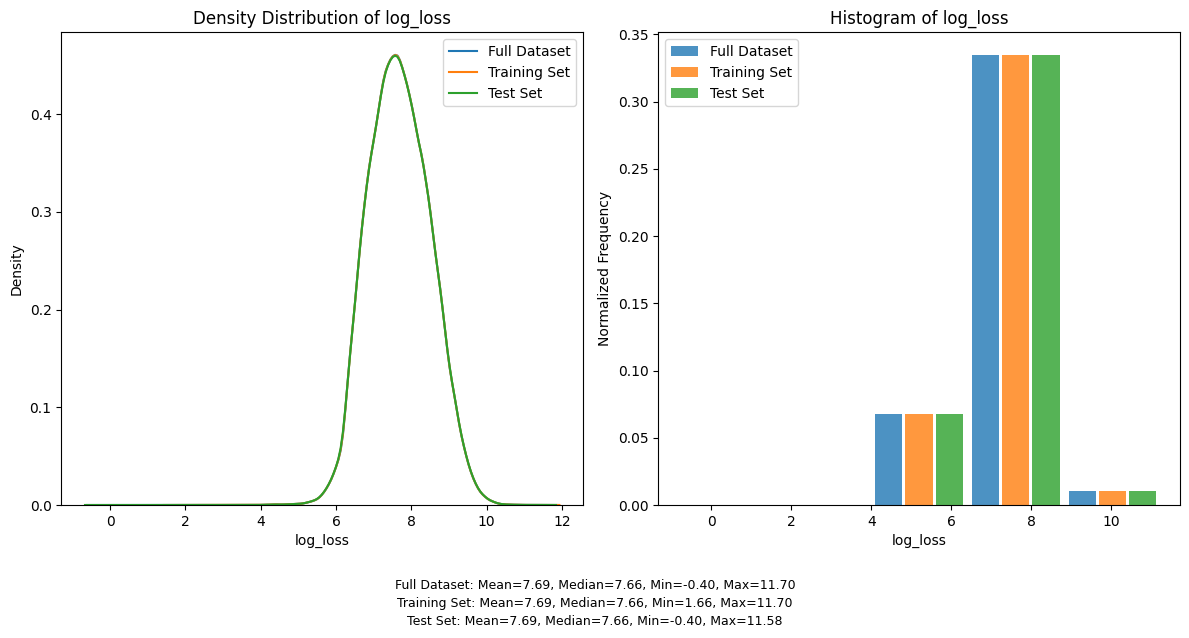

In [15]:
plot_dfs_distr(
    preprocessed_df, df_train, df_test, 
    target_column='log_loss',
    labels=['Full Dataset', 'Training Set', 'Test Set'],
    bins=5
)

In [16]:
# Define output directory and file paths
output_dir = os.path.dirname(SARCOS_PATH)
train_output_path = os.path.join(output_dir, 'allstate_claims_training.csv')
test_output_path = os.path.join(output_dir, 'allstate_claims_testing.csv')

# Save and verify training dataset
loaded_train_df = save_and_verify_dataset(
    df_train, 
    train_output_path, 
    dataset_name="Training data",
    target_column="log_loss"
)

# Save and verify testing dataset
loaded_test_df = save_and_verify_dataset(
    df_test, 
    test_output_path, 
    dataset_name="Testing data",
    target_column="log_loss"
)

# Verify both datasets together
print("\nVerifying target column position across both datasets:")
if (loaded_train_df.columns[-1] == "log_loss" and 
    loaded_test_df.columns[-1] == "log_loss"):
    print("✓ Target column 'log_loss' is correctly positioned as the last column in both datasets")
else:
    print("✗ Target column is not in the expected position in one or both datasets")


Training data saved to: C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims\allstate_claims_training.csv

Loaded training data from: C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims\allstate_claims_training.csv
Shape of loaded training data: (125545, 1083)

Analysis of the loaded training data:
Number of rows: 125545
Number of columns: 1083

--- Column Names and Statistics ---
- Column100_C               | Min: 0 | Max: 1 | Unique: 2
- Column100_D               | Min: 0 | Max: 1 | Unique: 2
- Column100_E               | Min: 0 | Max: 1 | Unique: 2
- Column100_F               | Min: 0 | Max: 1 | Unique: 2
- Column100_G               | Min: 0 | Max: 1 | Unique: 2
- Column100_H               | Min: 0 | Max: 1 | Unique: 2
- Column100_I               | Min: 0 | Max: 1 | Unique: 2
- Column100_J               | Min: 0 | Max: 1 | Unique: 2
- Column100_K               | Min: 0 | Max: 1 | Unique: 2
- Column100_M               | Min: 0 | Max: 1 | Uni

In [17]:
def create_stratified_kfolds(
    df: pd.DataFrame,
    output_dir: str,
    label_column: str = 'log_loss',
    n_folds: int = 4,
    seed: int = 42
) -> None:
    """
    Creates stratified k-folds from a dataframe and saves each fold to separate directories.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe to split into folds
    output_dir : str
        Base directory to save the folds
    label_column : str, default='log_loss'
        Column to use for stratification
    n_folds : int, default=4
        Number of folds to create
    seed : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    None
    """
    np.random.seed(seed)
    print(f"Random seed set to: {seed}")
    
    # Sort the data by labels for stratification
    y = df[label_column].values.reshape(-1, 1)
    sorted_indices = np.argsort(y, axis=0).flatten()
    df_sorted = df.iloc[sorted_indices].reset_index(drop=True)
    
    # Calculate the number of samples and group size
    num_samples = len(df)
    group_size = n_folds  # Each sample will be assigned to one of n_folds groups
    
    # Lists to hold fold indices
    fold_indices = [[] for _ in range(n_folds)]
    
    # Divide samples into groups of n_folds and distribute
    for i in range(0, num_samples, group_size):
        # Get indices for the current group
        group_indices = list(range(i, min(i + group_size, num_samples)))
        
        # If the group is smaller than n_folds, adjust distribution
        if len(group_indices) < group_size:
            # Duplicate some indices to make it equal to group_size
            extended_indices = group_indices * (group_size // len(group_indices) + 1)
            group_indices = extended_indices[:group_size]
        
        # Randomly shuffle the group indices
        np.random.shuffle(group_indices)
        
        # Distribute indices to folds
        for j, idx in enumerate(group_indices):
            if j < len(fold_indices):
                fold_indices[j].append(idx)
    
    # Create all folds and plot distributions
    fold_dfs = []
    all_fold_names = []
    
    # For tracking overall distributions
    all_subtraining_dfs = []
    all_validation_dfs = []
    
    for fold_num in range(n_folds):
        # Select validation indices for this fold
        val_indices = fold_indices[fold_num]
        
        # All other indices go to subtraining
        subtrain_indices = []
        for i in range(n_folds):
            if i != fold_num:
                subtrain_indices.extend(fold_indices[i])
        
        # Create subtraining and validation dataframes
        df_subtrain = df_sorted.iloc[subtrain_indices].reset_index(drop=True)
        df_val = df_sorted.iloc[val_indices].reset_index(drop=True)
        
        # Add to lists for plotting later
        all_subtraining_dfs.append(df_subtrain)
        all_validation_dfs.append(df_val)
        fold_dfs.extend([df_subtrain, df_val])
        all_fold_names.extend([f"Fold {fold_num} - Subtraining", f"Fold {fold_num} - Validation"])
        
        # Create directory for this fold
        fold_dir = os.path.join(output_dir, f"fold{fold_num}")
        os.makedirs(fold_dir, exist_ok=True)
        
        # Save files
        subtrain_path = os.path.join(fold_dir, 'allstate_claims_subtraining.csv')
        val_path = os.path.join(fold_dir, 'allstate_claims_validation.csv')
        
        df_subtrain.to_csv(subtrain_path, index=False)
        df_val.to_csv(val_path, index=False)
        
        # Print statistics
        print(f"\nFold {fold_num}:")
        print(f"Subtraining samples: {len(df_subtrain)} ({len(df_subtrain)/num_samples:.2%})")
        print(f"Validation samples: {len(df_val)} ({len(df_val)/num_samples:.2%})")
        print(f"Subtraining {label_column} range: {df_subtrain[label_column].min():.4f} to {df_subtrain[label_column].max():.4f}")
        print(f"Validation {label_column} range: {df_val[label_column].min():.4f} to {df_val[label_column].max():.4f}")
    
    # Plot distributions - comparing each fold's subtraining and validation to original
    print("\nPlotting distributions...")
    
    # Add original dataframe for comparison
    fold_dfs.insert(0, df)
    all_fold_names.insert(0, "Original Training Data")
    
    # Plot all distributions together
    plot_dfs_distr(*fold_dfs, target_column=label_column, labels=all_fold_names, figsize=(15, 8), bins=5)
    
    # Plot subtraining sets compared to original
    plot_dfs_distr(df, *all_subtraining_dfs, 
                   target_column=label_column, 
                   labels=["Original"] + [f"Fold {i} Subtraining" for i in range(n_folds)],
                   figsize=(15, 8), bins=15)
    
    # Plot validation sets compared to original
    plot_dfs_distr(df, *all_validation_dfs, 
                   target_column=label_column, 
                   labels=["Original"] + [f"Fold {i} Validation" for i in range(n_folds)],
                   figsize=(15, 8), bins=15)
    
    print(f"\nAll {n_folds} folds created and saved to {output_dir}")

Random seed set to: 42

Fold 0:
Subtraining samples: 94161 (75.00%)
Validation samples: 31387 (25.00%)
Subtraining log_loss range: 1.6582 to 11.7036
Validation log_loss range: 1.7918 to 11.7036

Fold 1:
Subtraining samples: 94161 (75.00%)
Validation samples: 31387 (25.00%)
Subtraining log_loss range: 1.6582 to 11.7036
Validation log_loss range: 2.3979 to 11.7036

Fold 2:
Subtraining samples: 94161 (75.00%)
Validation samples: 31387 (25.00%)
Subtraining log_loss range: 1.7918 to 11.7036
Validation log_loss range: 1.6582 to 11.7036

Fold 3:
Subtraining samples: 94161 (75.00%)
Validation samples: 31387 (25.00%)
Subtraining log_loss range: 1.6582 to 11.7036
Validation log_loss range: 2.3026 to 11.7036

Plotting distributions...


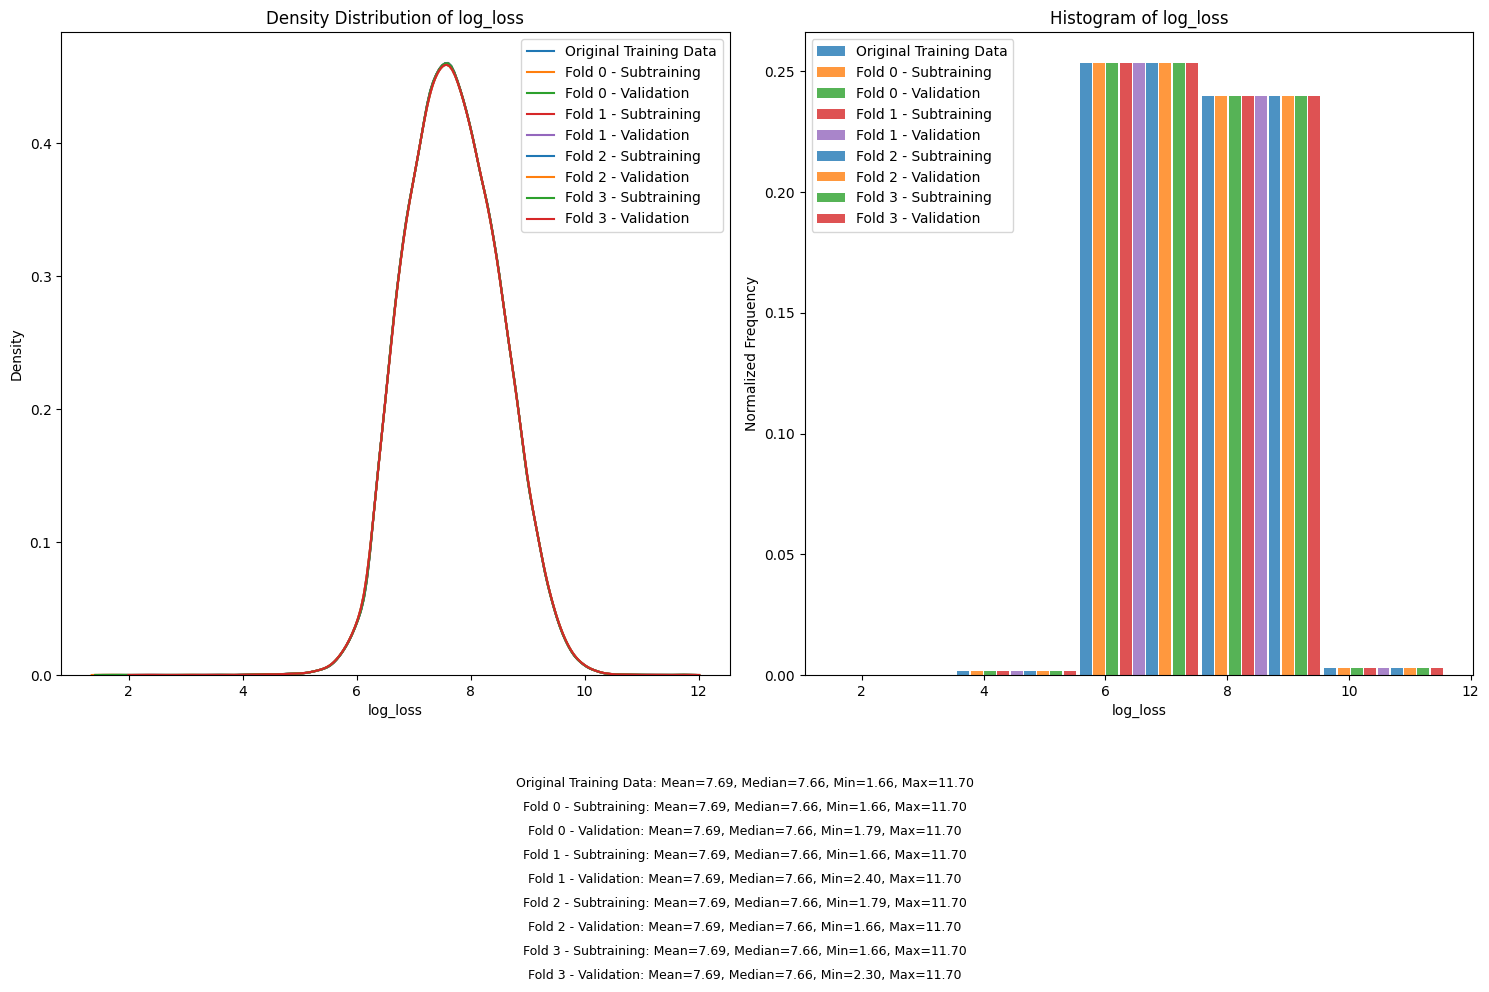

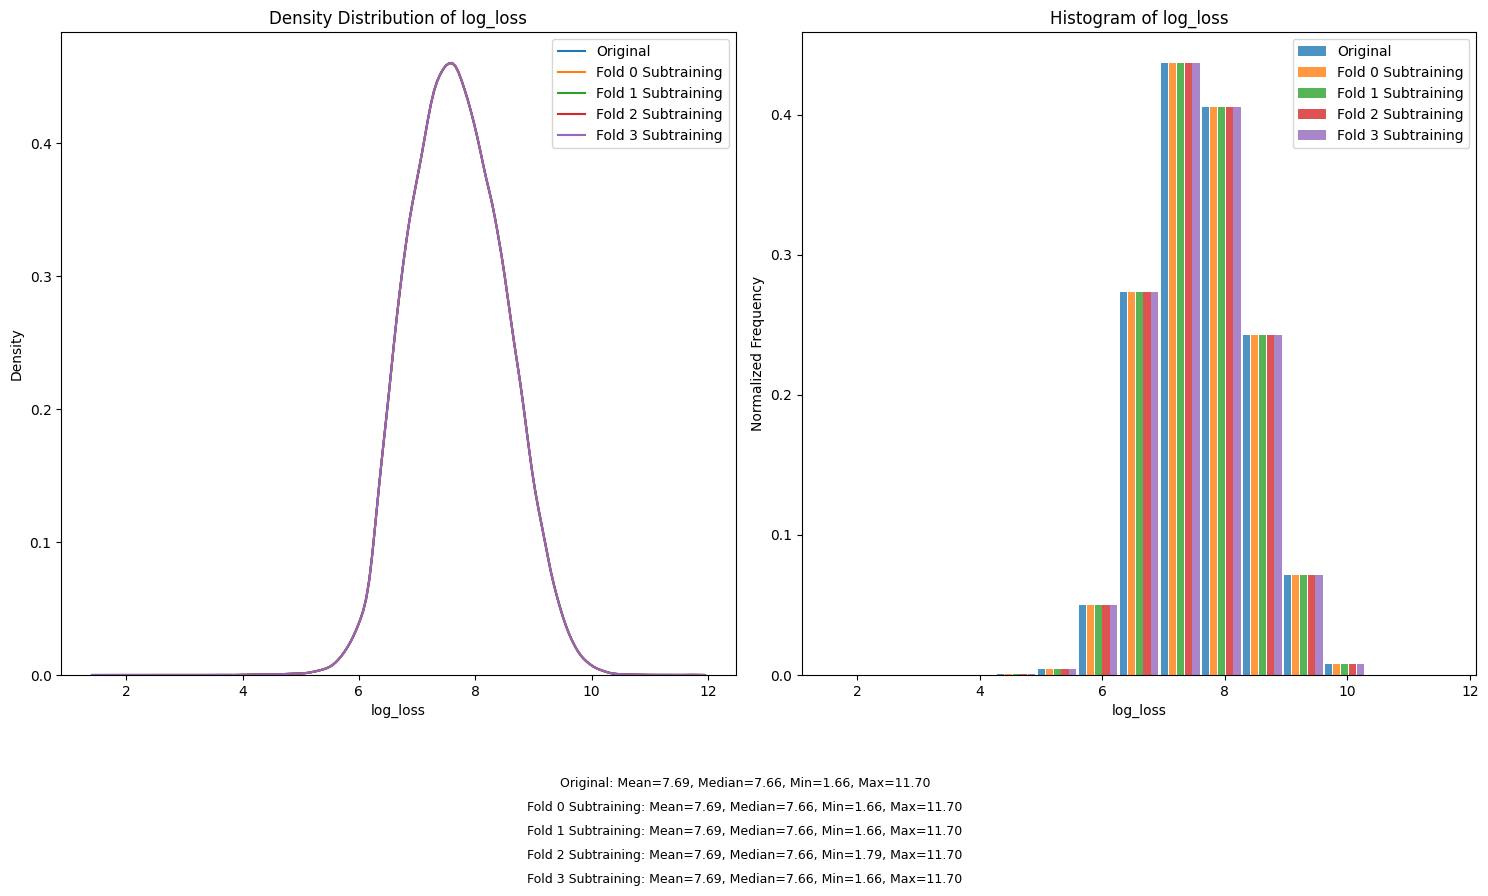

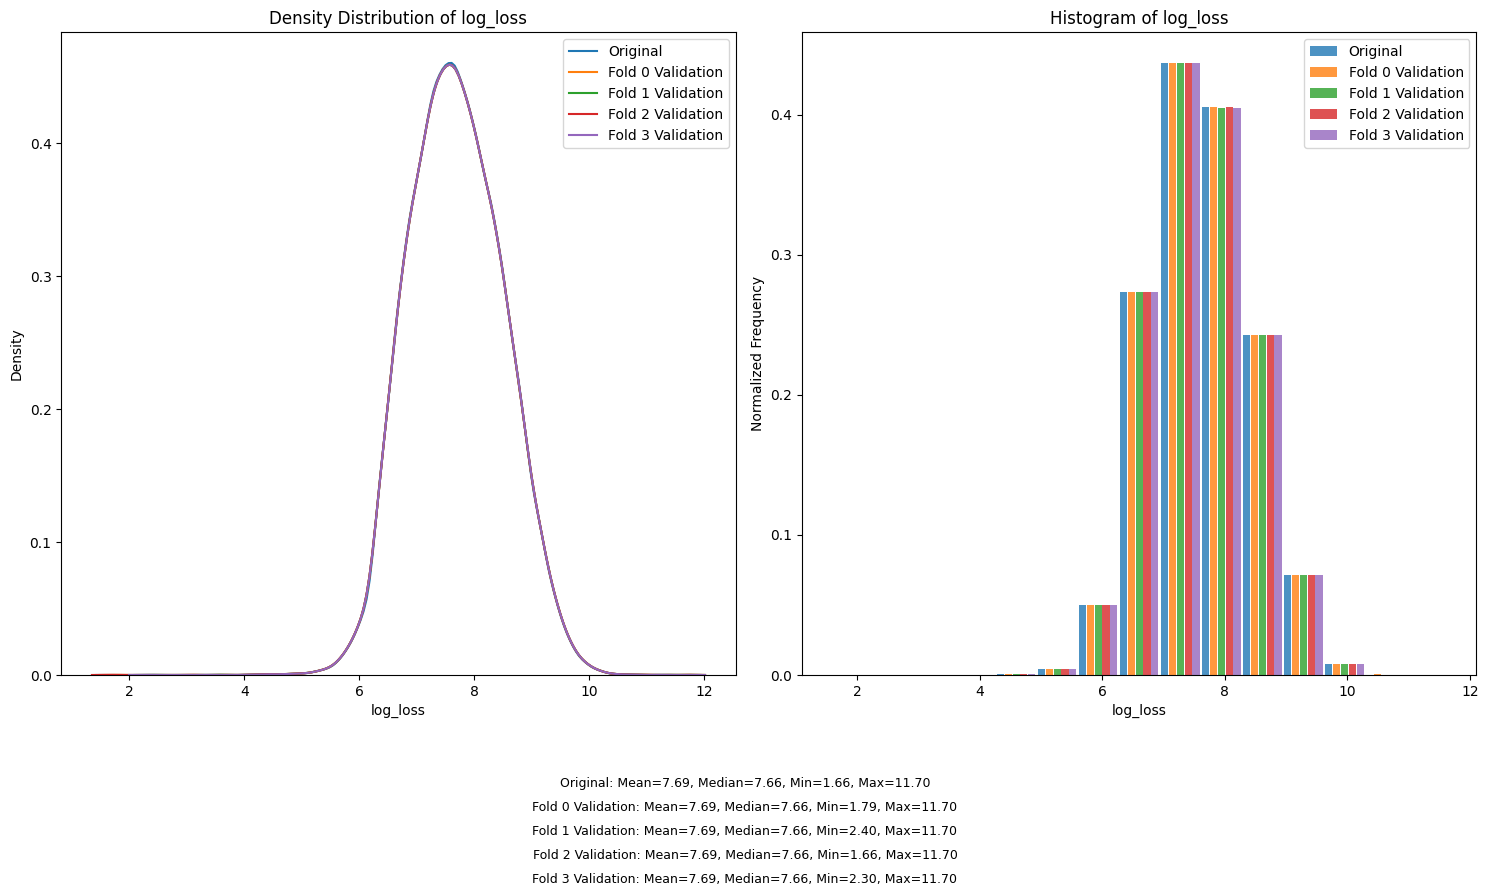


All 4 folds created and saved to C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims


In [18]:
# Create the folds
create_stratified_kfolds(
    df=df_train,  # Your training dataframe
    output_dir=output_dir,  # The directory where to save fold directories
    label_column="log_loss",
    n_folds=4,
    seed=42
)

In [19]:
def build_asc_ds(file_path: str, shuffle_data: bool = False, random_state: int = 42) -> tuple:
    """
    Build all state claims dataset by loading CSV and splitting into features and label.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file (e.g., 'allstate_claims_training.csv')
    shuffle_data : bool, default=False
        Whether to shuffle the dataset
    random_state : int, default=42
        Random seed for reproducibility when shuffling
        
    Returns:
    --------
    tuple
        X : np.ndarray - Feature columns
        y : np.ndarray - Target variable ('log_loss')
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Check if the last column is ln_peak_intensity as expected
    if df.columns[-1] != "log_loss":
        print(f"Warning: Expected 'log_loss' as the last column, found '{df.columns[-1]}' instead")
    
    # Split into features and labels
    # Skip the id column (penultimate column) and get the last column as target
    X = df.iloc[:, :-2].values  # All columns except the last two, as numpy array
    y = df.iloc[:, -1].values   # Just the last column, as numpy array
    
    # Shuffle if requested
    if shuffle_data:
        # Create a shuffled index
        idx = np.arange(len(df))
        np.random.seed(random_state)
        np.random.shuffle(idx)
        
        # Reindex X and y using the shuffled indices
        X = X[idx]
        y = y[idx]
        
        print(f"Data shuffled with random_state={random_state}")
    
    print(f"Dataset built from {file_path}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    
    return X, y

In [20]:
# Build the training dataset
X_train, y_train = build_asc_ds(train_output_path, shuffle_data=True, random_state=42)

# Build the testing dataset
X_test, y_test = build_asc_ds(test_output_path, shuffle_data=False, random_state=42)




Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims\allstate_claims_training.csv
X shape: (125545, 1081), y shape: (125545,)
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims\allstate_claims_testing.csv
X shape: (62773, 1081), y shape: (62773,)


In [21]:
def load_folds_asc_ds(
        base_dir: str,
        shuffle: bool = True,
        random_state: Optional[int] = None,
        debug: bool = False
) -> Generator[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray], None, None]:
    """
    Loads pre-split stratified folds from the all state claims directory structure using build_asc_ds function
    and yields one fold at a time.

    Directory structure expected:
    base_dir/
        fold0/
            allstate_claims_subtraining.csv
            allstate_claims_validation.csv
        fold1/
            allstate_claims_subtraining.csv
            allstate_claims_validation.csv
        ...

    Parameters:
        base_dir (str): Path to the directory containing the fold directories
        shuffle (bool): Whether to shuffle the data. Default is False.
        random_state (Optional[int]): Random seed for reproducibility. Default is None.
        debug (bool): Whether to enable debug printing. Default is False.

    Yields:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Split feature and label data:
            - X_subtrain: Features for the subtraining set (numpy array)
            - y_subtrain: Labels for the subtraining set (numpy array)
            - X_val: Features for the validation set (numpy array)
            - y_val: Labels for the validation set (numpy array)

    Raises:
        FileNotFoundError: If any expected fold directory or file is missing
    """
    
    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"Base directory not found: {base_dir}")
    
    # Process each fold
    for fold_idx in range(4):
        fold_dir = os.path.join(base_dir, f"fold{fold_idx}")
        
        if not os.path.exists(fold_dir):
            raise FileNotFoundError(f"Missing fold directory: {fold_dir}")
        
        # Path to subtraining and validation files
        subtrain_file = os.path.join(fold_dir, "allstate_claims_subtraining.csv")
        val_file = os.path.join(fold_dir, "allstate_claims_validation.csv")
        
        # Check file existence
        if not os.path.exists(subtrain_file):
            raise FileNotFoundError(f"Missing subtraining file: {subtrain_file}")
        if not os.path.exists(val_file):
            raise FileNotFoundError(f"Missing validation file: {val_file}")
        
        # Load data using build_sep_ds - returns numpy arrays
        X_subtrain, y_subtrain = build_asc_ds(
            file_path=subtrain_file,
            shuffle_data=shuffle,
            random_state=random_state
        )
        
        X_val, y_val = build_asc_ds(
            file_path=val_file,
            shuffle_data=shuffle,
            random_state=random_state
        )
        
        if debug:
            print(f"Fold {fold_idx}:")
            print(f"Subtraining shapes: X={X_subtrain.shape}, y={y_subtrain.shape}")
            print(f"Validation shapes: X={X_val.shape}, y={y_val.shape}")
            print(f"Subtraining range: {y_subtrain.min():.4f} to {y_subtrain.max():.4f}")
            print(f"Validation range: {y_val.min():.4f} to {y_val.max():.4f}")
        
        yield X_subtrain, y_subtrain, X_val, y_val

In [22]:
# load the folds
generator = load_folds_asc_ds(
    base_dir=output_dir,
    shuffle=True,
    random_state=42,
    debug=True
)

# get the first fold
X_subtrain, y_subtrain, X_val, y_val = next(generator)

# print the shapes
print(f"X_subtrain shape: {X_subtrain.shape}, y_subtrain shape: {y_subtrain.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims\fold0\allstate_claims_subtraining.csv
X shape: (94161, 1081), y shape: (94161,)
Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims\fold0\allstate_claims_validation.csv
X shape: (31387, 1081), y shape: (31387,)
Fold 0:
Subtraining shapes: X=(94161, 1081), y=(94161,)
Validation shapes: X=(31387, 1081), y=(31387,)
Subtraining range: 1.6582 to 11.7036
Validation range: 1.7918 to 11.7036
X_subtrain shape: (94161, 1081), y_subtrain shape: (94161,)
X_val shape: (31387, 1081), y_val shape: (31387,)


In [26]:
def plot_avsp_asc(
    model: tf.keras.Model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    title: str,
    prefix: str,
    l_threshold: float = 5,
    u_threshold: float = 10.5,
    use_dict: bool = False
) -> str:
    """
    Plots actual vs predicted log_loss values.

    Parameters:
    - model (tf.keras.Model): The trained model to evaluate
    - X_test (np.ndarray): Test features
    - y_test (np.ndarray): True target values for the test set
    - title (str): The title of the plot
    - prefix (str): Prefix for the plot file names
    - l_threshold (float): Lower threshold - values below this are considered rare
    - u_threshold (float): Upper threshold - values above this are considered rare
    - use_dict (bool): Whether the model returns a dictionary with output names. Default is False.

    Returns:
    - str: The absolute path to the saved plot file
    """
    
    # Make predictions
    if use_dict:
        res = model.predict(X_test)
        predictions = res['output']
    else:
        _, predictions = model.predict(X_test)
        
    # Process predictions if needed (flatten if multidimensional)
    predictions = np.array(predictions).flatten()
    y_test = np.array(y_test).flatten()
    
    # Create the figure with proper axes configuration
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Scatter plot with a colormap based on prediction error
    prediction_error = np.abs(y_test - predictions)
    norm = plt.Normalize(np.min(prediction_error), np.max(prediction_error))
    cmap = plt.cm.viridis
    
    scatter = ax.scatter(y_test, predictions, c=prediction_error, cmap=cmap, norm=norm, alpha=0.7, s=40)
    
    # Plot perfect prediction line
    min_intensity = min(np.min(y_test), np.min(predictions))
    max_intensity = max(np.max(y_test), np.max(predictions))
    ax.plot([min_intensity, max_intensity], [min_intensity, max_intensity], 'k--', label='Perfect Prediction')
    
    # Add dashed lines at thresholds on both axes if thresholds are provided
    if l_threshold is not None:
        ax.axvline(l_threshold, color='blue', linestyle='--', label='Lower Threshold')
        ax.axhline(l_threshold, color='blue', linestyle='--')
    
    if u_threshold is not None:
        ax.axvline(u_threshold, color='red', linestyle='--', label='Upper Threshold')
        ax.axhline(u_threshold, color='red', linestyle='--')
    
    # Add labels and title
    ax.set_xlabel('Actual log_loss')
    ax.set_ylabel('Predicted log_loss')
    ax.set_title(f"{title}\n{prefix}_Actual_vs_Predicted_log_loss")
    
    # Add colorbar for prediction error
    cbar = fig.colorbar(scatter, ax=ax, label='Prediction Error', extend='both')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Highlight regions if thresholds are provided
    if l_threshold is not None and u_threshold is not None:
        # Add shaded region for frequent values (between thresholds)
        ax.axvspan(l_threshold, u_threshold, alpha=0.1, color='green', label='Frequent Region')
        
        # Add annotations for rare and frequent regions
        ax.annotate('Rare', xy=(min_intensity, (min_intensity + l_threshold)/2), 
                   xycoords='data', fontsize=10, color='blue')
        ax.annotate('Frequent', xy=((l_threshold + u_threshold)/2, (l_threshold + u_threshold)/2), 
                   xycoords='data', fontsize=10, color='green')
        ax.annotate('Rare', xy=(u_threshold + (max_intensity-u_threshold)/2, u_threshold + (max_intensity-u_threshold)/2), 
                   xycoords='data', fontsize=10, color='red')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"{title}_{prefix}_actual_vs_predicted_log_loss.png"
    plt.savefig(plot_filename)
    plt.close()
    
    return os.path.abspath(plot_filename)

In [27]:
def create_simple_mlp_model(input_shape, hidden_layers=[64, 32], activation='relu', dropout_rate=0.2):
    """
    Create a simple MLP model for regression.
    
    Parameters:
    - input_shape: Shape of input features
    - hidden_layers: List of neurons in each hidden layer
    - activation: Activation function to use
    - dropout_rate: Dropout rate for regularization
    
    Returns:
    - Compiled TensorFlow model
    """
    
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # Add hidden layers
    for units in hidden_layers:
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # This is the representation layer
    representation = x
    
    # Add main output layer (regression - no activation)
    main_output = tf.keras.layers.Dense(1, name="main_output")(x)
    
    # Create and compile model
    model = tf.keras.Model(inputs=inputs, outputs=[representation, main_output])
    model.compile(
        optimizer='adam',
        loss={
            'main_output': 'mse'
        }
    )
    
    return model

# Example usage:
def test_plot_avsp(X_train, y_train, X_test, y_test):
    """
    Train a simple MLP model and test the plot_avsp function.
    
    Parameters:
    - X_train: Training features
    - y_train: Training target values
    - X_test: Test features
    - y_test: Test target values
    
    Returns:
    - Path to the generated plot
    """
    # Create and train model
    input_shape = (X_train.shape[1],)
    model = create_simple_mlp_model(input_shape)
    
    print("Model summary:")
    model.summary()
    
    
    # Generate and save plot
    print("\nGenerating plot...")
    plot_path = plot_avsp_asc(
        model=model,
        X_test=X_test,
        y_test=y_test,
        title="MLP Model Performance",
        prefix="test_model"
    )
    
    print(f"Plot saved at: {plot_path}")
    return plot_path

In [28]:
plot_path = test_plot_avsp(X_subtrain, y_subtrain, X_val, y_val)
print(plot_path)

Model summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1081)]            0         
                                                                 
 dense (Dense)               (None, 64)                69248     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                              

In [29]:
def filter_ds(
        X: np.ndarray, y: np.ndarray,
        low_threshold: float, high_threshold: float,
        N: int = 500, bins: int = 10, seed: int = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Filter and sample the dataset based on the threshold values of y with a random seed for reproducibility.

    This function creates a subset of the dataset where all samples where y is either
    below the low_threshold or above the high_threshold are included. Samples where y
    is between the low_threshold and high_threshold are randomly sampled within bins
    to have a total of N samples in the resulting dataset, using a specified seed for
    random number generation.

    Parameters:
        X (np.ndarray): The input features of the dataset.
        y (np.ndarray): The output labels of the dataset.
        low_threshold (float): The lower bound threshold for selecting high delta values.
        high_threshold (float): The upper bound threshold for selecting high delta values.
        N (int): The number of samples to include from the low delta range.
        bins (int): The number of bins to split the low delta range into.
        seed (int, optional): Seed for the random number generator to ensure reproducibility.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The filtered and sampled input features and output labels.
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Flatten the output array to ensure mask works properly with input dimensions
    y_flat = y.flatten()

    # Create a mask to identify high delta samples (below low_threshold or above high_threshold)
    high_deltas_mask = (y_flat <= low_threshold) | (y_flat >= high_threshold)

    # Apply the high deltas mask to get the corresponding samples
    X_high_deltas = X[high_deltas_mask, :]
    y_high_deltas = y[high_deltas_mask, :]

    # Create a mask to identify low delta samples (between low_threshold and high_threshold)
    low_deltas_mask = (y_flat > low_threshold) & (y_flat < high_threshold)

    # Apply the low deltas mask to get the corresponding samples
    X_low_deltas = X[low_deltas_mask, :]
    y_low_deltas = y[low_deltas_mask, :]

    # Create bin edges for the low delta samples
    bins_edges = np.linspace(low_threshold, high_threshold, bins + 1)

    # Digitize y_low_deltas to assign each sample to a bin
    binned_indices = np.digitize(y_low_deltas.flatten(), bins_edges) - 1

    # Determine the budget per bin and remainder
    budget = N // bins
    remainder = N % bins

    # Initialize lists to store sampled low delta values
    X_low_deltas_sampled = []
    y_low_deltas_sampled = []

    # Sample low delta values from each bin
    for bin_idx in range(bins):
        # Create a mask for the current bin
        bin_mask = binned_indices == bin_idx

        # Select samples in the current bin
        X_bin = X_low_deltas[bin_mask, :]
        y_bin = y_low_deltas[bin_mask, :]

        # Determine the number of samples to draw from this bin
        bin_budget = budget + (1 if remainder > 0 else 0)
        remainder = max(0, remainder - 1)

        # Sample from the bin if it has more samples than the budget
        if len(y_bin) > bin_budget:
            sampled_indices = np.random.choice(len(X_bin), size=bin_budget, replace=False)
            X_low_deltas_sampled.append(X_bin[sampled_indices])
            y_low_deltas_sampled.append(y_bin[sampled_indices])
        else:
            # If the bin has fewer samples than the budget, include all samples
            X_low_deltas_sampled.append(X_bin)
            y_low_deltas_sampled.append(y_bin)
            remainder += bin_budget - len(y_bin)

    # Distribute the remaining budget to the center bins
    center_bins = np.arange(bins // 4, 3 * bins // 4)
    for bin_idx in center_bins:
        if remainder <= 0:
            break
        bin_mask = binned_indices == bin_idx
        X_bin = X_low_deltas[bin_mask, :]
        y_bin = y_low_deltas[bin_mask, :]

        if len(y_bin) > len(X_low_deltas_sampled[bin_idx]):
            additional_needed = min(remainder, len(y_bin) - len(X_low_deltas_sampled[bin_idx]))
            sampled_indices = np.random.choice(
                np.arange(len(y_bin)),
                size=additional_needed,
                replace=False
            )
            X_low_deltas_sampled[bin_idx] = np.concatenate((X_low_deltas_sampled[bin_idx], X_bin[sampled_indices]))
            y_low_deltas_sampled[bin_idx] = np.concatenate((y_low_deltas_sampled[bin_idx], y_bin[sampled_indices]))
            remainder -= additional_needed

    # Concatenate all sampled low delta values
    X_low_deltas_sampled = np.concatenate(X_low_deltas_sampled, axis=0)
    y_low_deltas_sampled = np.concatenate(y_low_deltas_sampled, axis=0)

    # Combine high delta samples with sampled low delta samples
    X_combined = np.concatenate([X_high_deltas, X_low_deltas_sampled], axis=0)
    y_combined = np.concatenate([y_high_deltas, y_low_deltas_sampled], axis=0)

    return X_combined, y_combined

In [24]:
# find the kde such that ratio is maintained on the training set
training_path = 'C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims/allstate_claims_training.csv'

# build training set
X_train, y_train = build_asc_ds(training_path, shuffle_data=True, random_state=42)

Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/allstate_claims/allstate_claims_training.csv
X shape: (125545, 1081), y shape: (125545,)


In [32]:
def analyze_label_dist_with_kde(y: np.ndarray, kde_bandwidth: float = 0.1, bin_width: float = 10) -> float:
    """
    Analyze label distribution with histogram and KDE overlay, and calculate density ratios.
    
    Parameters:
    -----------
    y : np.ndarray
        The array of label values to analyze
    kde_bandwidth : float, default=0.1
        The bandwidth parameter for KDE
    bin_width : float, default=10
        The width of each histogram bin
        
    Returns:
    --------
    float
        KDE density_ratio: The ratio between highest and lowest non-zero density
    """
    # Find minimum and maximum values in the array
    min_y_value = np.min(y)
    max_y_value = np.max(y)
    
    # Calculate number of bins based on bin_width
    range_y = max_y_value - min_y_value
    num_bins = int(np.ceil(range_y / bin_width))
    
    # Create a histogram to find the frequencies
    counts, bins = np.histogram(y, bins=num_bins)
    
    # Find the minimum and maximum frequencies and their corresponding values
    min_freq = np.min(counts[counts > 0])  # Minimum non-zero frequency
    max_freq = np.max(counts)
    
    # Find the bin indices for min and max frequencies
    min_freq_idx = np.where(counts == min_freq)[0][0]
    max_freq_idx = np.where(counts == max_freq)[0][0]
    
    # Get the corresponding y values (using bin centers)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    min_freq_value = bin_centers[min_freq_idx]
    max_freq_value = bin_centers[max_freq_idx]

    # Calculate ratio between min and max frequencies
    freq_ratio = max_freq / min_freq if min_freq > 0 else float('inf')
    
    # Print the key frequency information
    print(f'Value with min frequency: {min_freq_value:.4f}, Frequency: {min_freq}')
    print(f'Value with max frequency: {max_freq_value:.4f}, Frequency: {max_freq}')
    print(f'Frequency ratio (max/min): {freq_ratio:.4f}')
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram in blue
    counts, bins, _ = plt.hist(y, bins=num_bins, alpha=0.6, color='blue', label=f'Histogram (bin width={bin_width})')
    
    # Compute KDE with specified bandwidth
    kde = gaussian_kde(y, bw_method=kde_bandwidth)
    
    # Generate points for plotting KDE
    x_grid = np.linspace(min_y_value - 0.5, max_y_value + 0.5, 1000)
    density = kde(x_grid)
    
    # Scale KDE to match histogram height for better visualization
    scale_factor = np.max(counts) / np.max(density)
    scaled_density = density * scale_factor
    
    # Plot scaled KDE in orange
    plt.plot(x_grid, scaled_density, color='orange', linewidth=2, label=f'KDE (bw={kde_bandwidth})')
    
    # Calculate KDE density ratio
    non_zero_density = density[density > 1e-10]
    max_density = np.max(non_zero_density)
    min_density = np.min(non_zero_density)
    density_ratio = max_density / min_density
    
    # Print KDE density information
    print(f'Min density: {min_density:.10f}')
    print(f'Max density: {max_density:.10f}')
    print(f'KDE density ratio (max/min): {density_ratio:.4f}')
    
    # Add ratio text to plot
    plt.text(0.05, 0.95, f'KDE density ratio: {density_ratio:.2f}\nFreq ratio: {freq_ratio:.2f}', 
            transform=plt.gca().transAxes, fontsize=12, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Set title and labels
    plt.title('Label Distribution with KDE Overlay')
    plt.xlabel('Label Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return density_ratio

Value with min frequency: 3.3325, Frequency: 1
Value with max frequency: 7.6658, Frequency: 11371
Frequency ratio (max/min): 11371.0000
Min density: 0.0000236505
Max density: 0.2702303738
KDE density ratio (max/min): 11426.0037


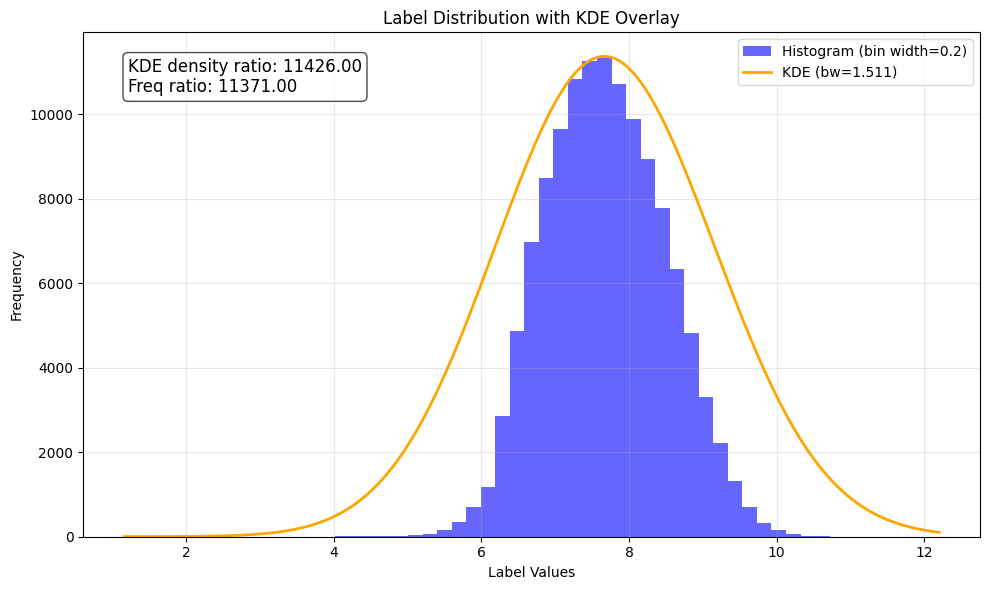

11426.003678370662

In [45]:
analyze_label_dist_with_kde(y_train, 1.511, bin_width=0.2)